# Classifying Satellites and Space Junk

Exploring the effectiveness of different machine learning models to classify objects in space as active satellites or 'other' objects in order to combat the threat of the Kessler Syndrome to valuable space assets.

Allen Qu

## Data Cleaning

In [1]:
# import essential libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# dataset containing active satellite data
satellites = pd.read_csv('data/active_sats.csv')

In [3]:
# dataset containing all observed objects outside of earth's atmosphere 
objects = pd.read_csv('data/all_objects.csv')

In [4]:
satellites.head()

,"Name of Satellite, Alternate Names",Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253
0,3Cat-1,NR (11/18),Spain,Universitat Politècnica de Catalunya,Civil,Technology Development,NaN,LEO,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aalto-1,Finland,Finland,University of Aalto,Civil,Technology Development,NaN,LEO,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAUSat-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"ABS-2 (Koreasat-8, ST-3)",NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,-75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
objects.head()

,OBJECT_ID,OBJECT_NAME,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,RCSVALUE,LAUNCH,COMMENT
0,2019-039K,COSMOS 2535 DEB,44633,CIS,97.67,97.87,688.0,607.0,NaN,0,NaN,NaN
1,2019-039J,COSMOS 2535 DEB,44632,CIS,96.77,97.85,615.0,593.0,NaN,0,NaN,NaN
2,2019-039H,COSMOS 2535 DEB,44631,CIS,96.76,97.85,626.0,581.0,NaN,0,NaN,NaN
3,2019-039G,COSMOS 2535 DEB,44630,CIS,96.39,97.86,597.0,574.0,NaN,0,NaN,NaN
4,2019-068B,PEGASUS R/B,44629,US,96.49,27.00,602.0,579.0,NaN,0,2019-10-11,NaN


In [6]:
# create df_obj dataframe for analysis
df_obj = objects[objects['COMMENT'].isnull()]
df_obj = df_obj.drop(columns = ['RCSVALUE', 'COMMENT'])

In [7]:
# rename columns for easy readability
satellites = satellites.rename(columns = {'NORAD Number':'NORAD_CAT_ID', 'Longitude of GEO (degrees)': 'lon', 
                                          'Name of Satellite, Alternate Names': 'name'})

In [8]:
# get number of active satellites 
active_norads = list(satellites['NORAD_CAT_ID'])
len(active_norads)

2062

## Feature Engineering

In [9]:
# add RCS (radar cross section) size
df_obj['RCS_SIZE'] = df_obj['RCS_SIZE'].replace('SMALL', 0)
df_obj['RCS_SIZE'] = df_obj['RCS_SIZE'].replace('MEDIUM', 1)
df_obj['RCS_SIZE'] = df_obj['RCS_SIZE'].replace('LARGE', 2)

In [10]:
# filter date to before april so datasets are matched
df_obj = df_obj[df_obj['LAUNCH'] < '2019-04']

In [11]:
# add eccentricity
a = df_obj['APOGEE']
p = df_obj['PERIGEE']
df_obj['ECCENTRICITY'] = (a-p)/(a+p+12740)

In [12]:
# count number of different countries that space objects belong to
countries = {}
count = 0
for country in df_obj['COUNTRY'].unique():
    countries[country] = count
    count += 1

In [13]:
# add country 
for k, v in countries.items():
    df_obj['COUNTRY'] = df_obj['COUNTRY'].replace(k, v)

In [14]:
# add orbital velocities at apogee and perigee
G = 6.673 * 10**-11
M = 5.98 * 10**24
GM = G * M
R_earth = 6.37 * 10**6

def velocity(altitude):
    return math.sqrt(GM/(altitude*1000 + R_earth))
    
df_obj['vel_apo'] = a.apply(lambda a: velocity(a))
df_obj['vel_per'] = p.apply(lambda a: velocity(a))

In [15]:
# function to label objects as either active satellite (1) or other (0)
def search_norad(num, list_norads):
    if num in list_norads:
        return 1
    else:
        return 0

In [16]:
# add object type (target - active satellite or 'other' object)
df_obj['obj_type'] = df_obj['NORAD_CAT_ID'].apply(lambda a: search_norad(a, active_norads))

In [17]:
# function to extract the year of launch
def get_year(launch_date):
    return str(launch_date)[0:4]

In [18]:
# add year of launch date
df_obj['LAUNCH'] = df_obj['LAUNCH'].apply(lambda y: get_year(y))

In [19]:
# drop nan launch rows
df_obj = df_obj[df_obj['LAUNCH'] != 'nan']

In [20]:
# count final number of active satellites (1) and other (0) objects in dataframe
df_obj['obj_type'].value_counts()

0    16993
1     1986
Name: obj_type, dtype: int64

In [21]:
# convert launch column to float data type 
df_obj['LAUNCH'] = df_obj['LAUNCH'].astype(float)

In [22]:
# drop empty rows
df_obj = df_obj.dropna()

In [23]:
df_obj

,OBJECT_ID,OBJECT_NAME,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH,ECCENTRICITY,vel_apo,vel_per,obj_type
12,2018-084R,H-2A DEB,44620,0,95.73,98.89,592.0,516.0,0.0,2018.0,0.005488,7570.841341,7612.505953,0
13,2018-048F,CZ-2D DEB,44619,1,97.29,98.15,643.0,615.0,0.0,2018.0,0.002000,7543.262741,7558.366543,0
14,2018-034K,CZ-4C DEB,44618,1,107.31,63.47,1135.0,1069.0,0.0,2018.0,0.004416,7291.817761,7324.093418,0
15,2018-034J,CZ-4C DEB,44617,1,107.39,63.41,1134.0,1078.0,0.0,2018.0,0.003745,7292.303607,7319.666944,0
16,2018-031K,CZ-4C DEB,44616,1,97.43,97.99,640.0,632.0,0.0,2018.0,0.000571,7544.876676,7549.185572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19855,1959-007A,VANGUARD 3,20,4,124.60,33.34,3263.0,509.0,1.0,1959.0,0.166788,6436.212497,7616.378172,0
19856,1958-002A,VANGUARD R/B,16,4,137.31,34.28,4226.0,650.0,1.0,1958.0,0.202997,6136.774705,7539.500917,0
19857,1959-001B,VANGUARD R/B,12,4,125.84,32.91,3327.0,554.0,1.0,1959.0,0.166837,6414.937901,7591.587898,0
19858,1959-001A,VANGUARD 2,11,4,121.46,32.87,2938.0,554.0,1.0,1959.0,0.146870,6547.612469,7591.587898,0


## EDA

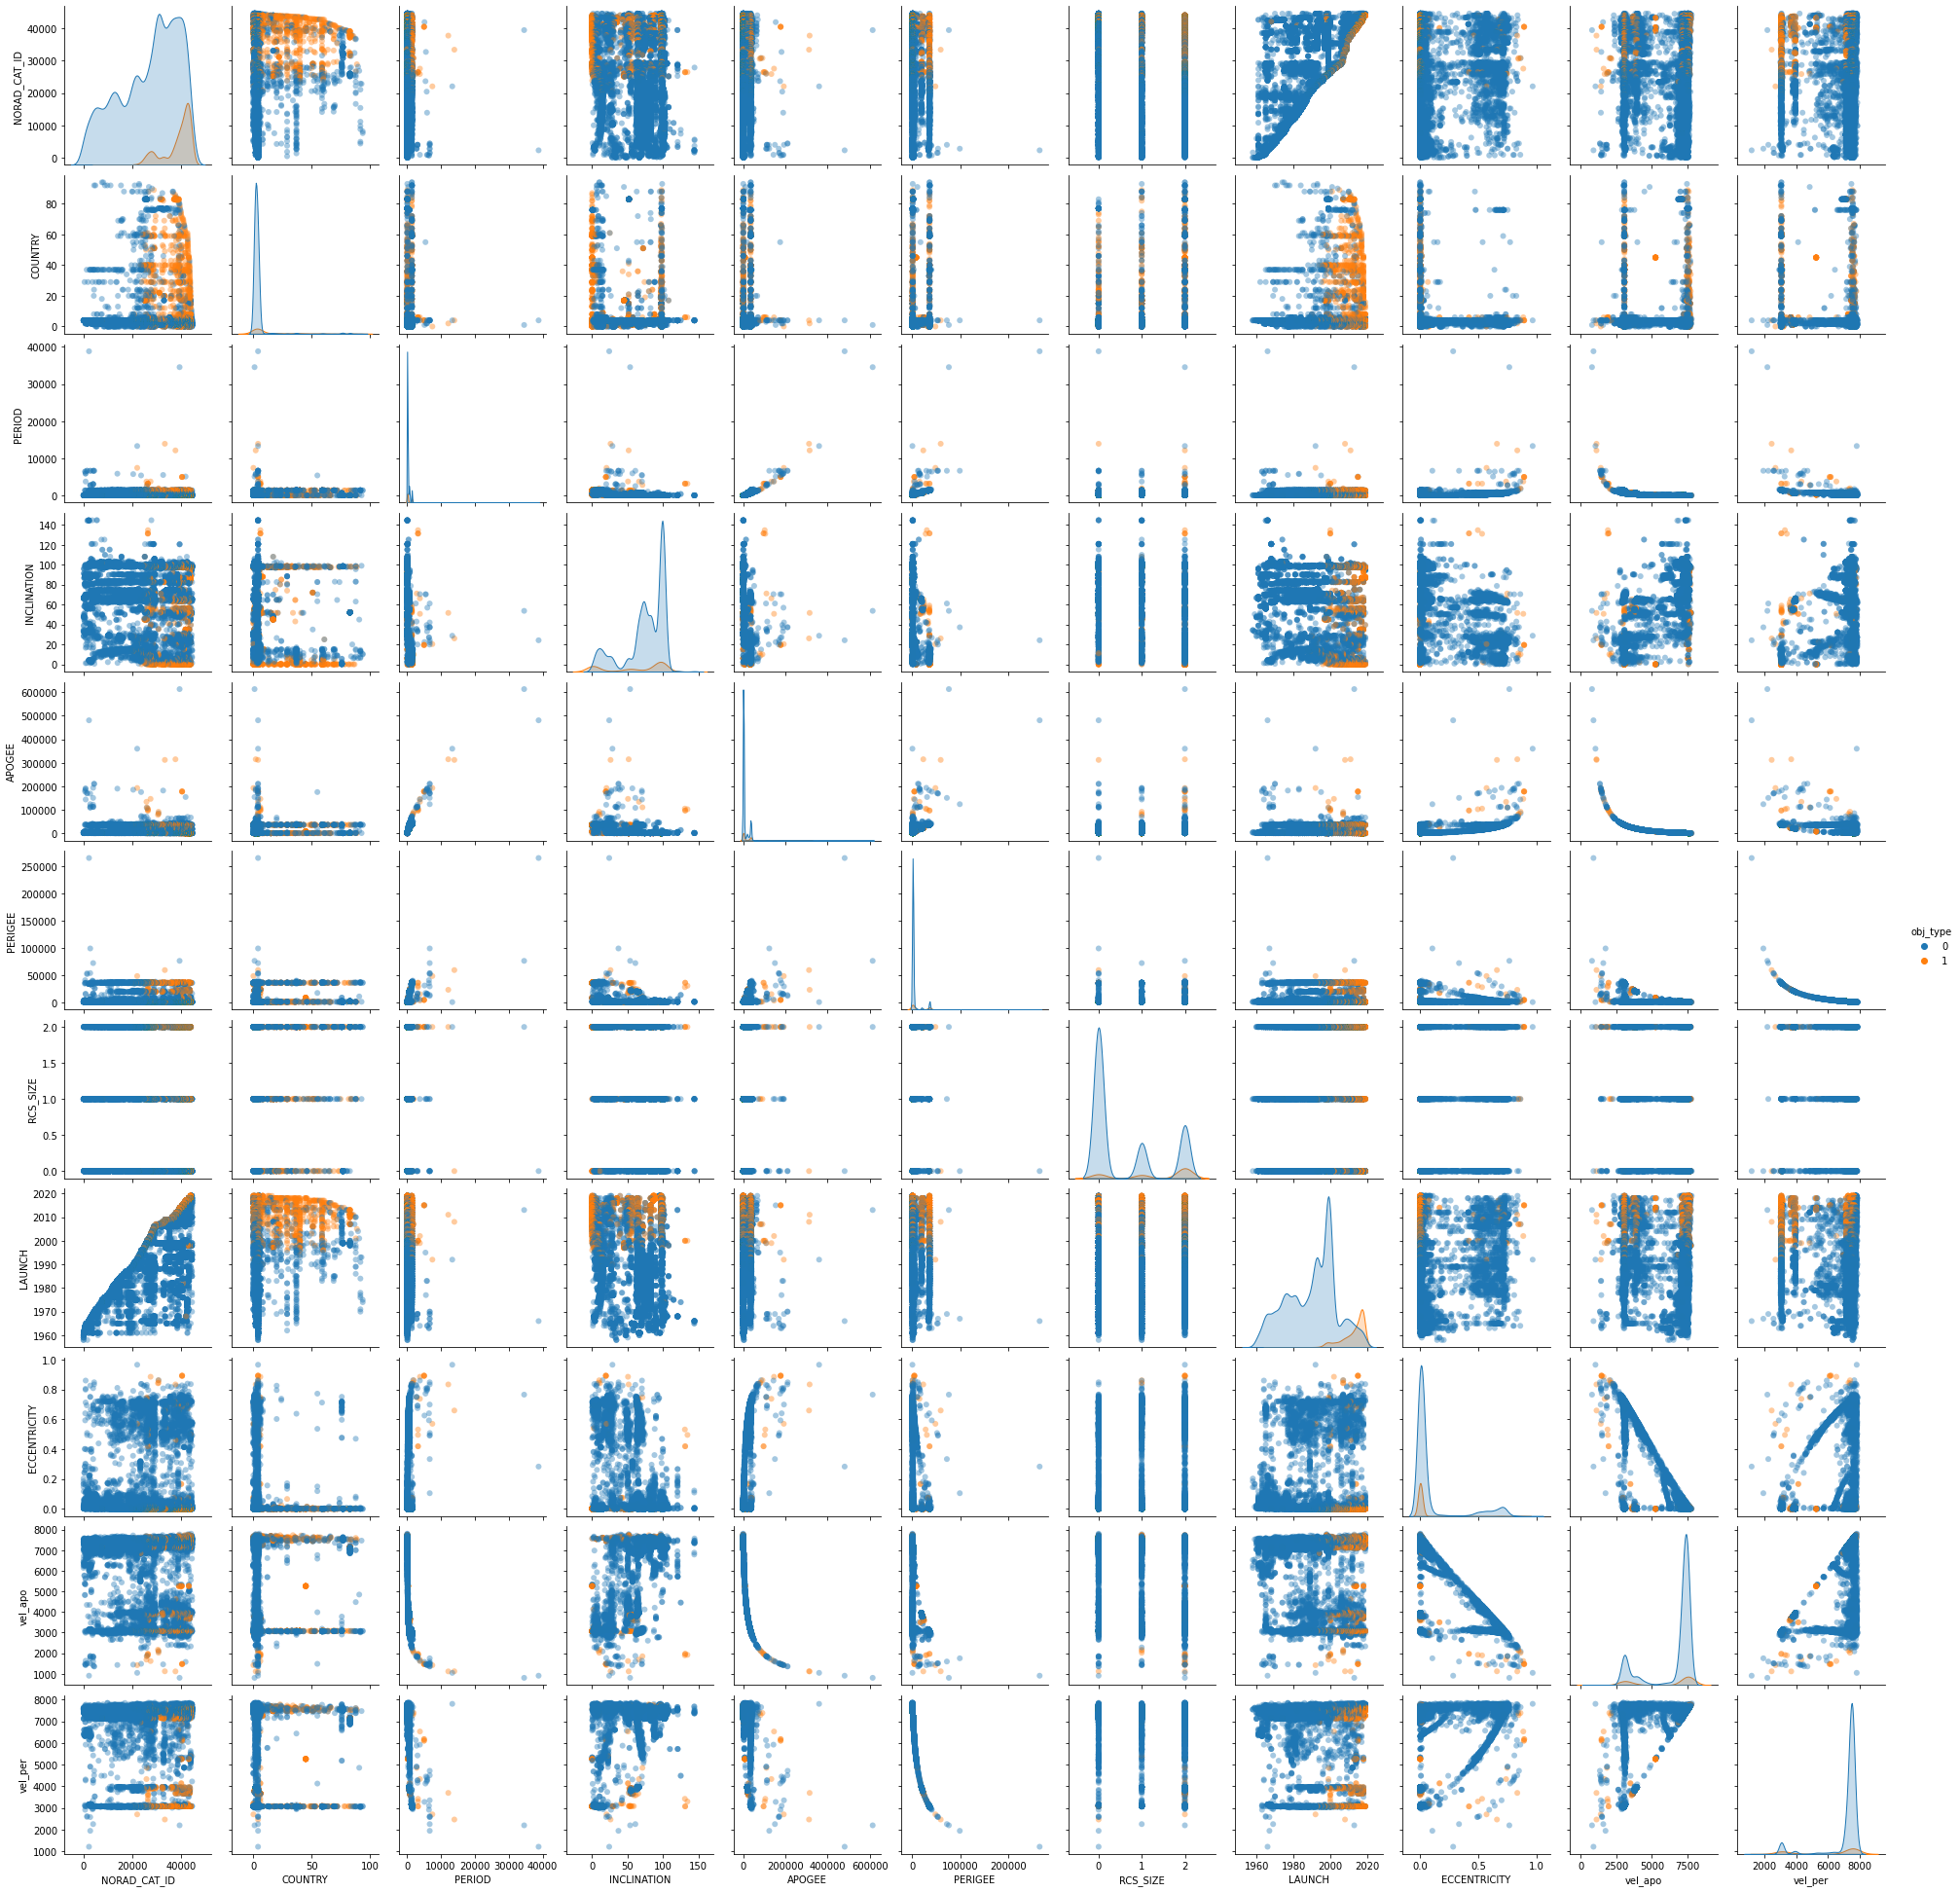

In [24]:
# analyze the relationship between different features to check for linearity
# as well as check for linear separability between active satellites (orange)
# and other objects (blue)
sns.pairplot(df_obj, hue='obj_type', plot_kws=dict(alpha=.4, edgecolor='none'))

Some patterns noticed from pair plots for separability:

1. Active satellite ID numbers seem to skew more towards higher numbers, while non-active space objects have ID numbers ranging from low to high.

2. Active satellites were usually launched into space more recently than 'other' objects.

3. While both active satellites and other space objects have a high number of samples with low eccentricity, active satellites seem to only have low eccentricity.

Hence, some important features to look out for when modeling include 'norad_cat_id', 'launch', and 'eccentricity'.

## Modeling and Analysis

In [25]:
# import libraries for  modeling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn.metrics import precision_recall_curve, confusion_matrix
from ipywidgets import interactive, FloatSlider
import imblearn.over_sampling
from sklearn import preprocessing

Using TensorFlow backend.


In [26]:
# dataframe for features
X = df_obj.drop(columns = ['OBJECT_ID', 'OBJECT_NAME', 'obj_type'], axis = 1)

In [27]:
# dataframe for target (active satellite or other object)
y = df_obj['obj_type']

In [28]:
# split data into 3: 60% train, 20% validation, 20% test
X_80, X_test, y_80, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_80, y_80, test_size=0.25, random_state=2019)

In [29]:
X_80.shape

(14853, 11)

In [30]:
X_train.shape

(11139, 11)

In [31]:
X_val.shape

(3714, 11)

In [32]:
X_test.shape

(3714, 11)

### Class Imbalance - Oversample Active Satellites

Since the number of non-active flying objects in space far outnumber that of active satellites, active satellites will be oversampled in this analysis.

In [33]:
other = np.sum(df_obj['obj_type'] == 0)
active = np.sum(df_obj['obj_type'] == 1)
weight = other/active
# Ratio of other objects to active satellites in dataset (Imbalance)
weight

8.797889182058048

In [34]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
multiple = n_neg / n_pos
ratio = {1 : int(n_pos * multiple), 0 : n_neg}

# randomly oversample positive samples
ROS = imblearn.over_sampling.RandomOverSampler(ratio = ratio, random_state=42)
X_os, y_os = ROS.fit_sample(X_train, y_train)

### Choosing and Using Appropriate Machine Learning Models 

Here, four machine learning models are chosen for the satellite classification task based on properties that seem relevant to the problem. These incluse Logistic Regression, K-Nearest Neighbors, Random Forest, and XGBoost models. Since the number of non-active satellites far outnumber the number of active satellites, accuracy is not a good indicator of how well a model performs in making correct decisions. Instead, the F1 score and AUC score are going to be used to measure the effectiveness of each model.  

### Logistic Regression

A logistic regression model seems to be appropriate for binary classification given the two targets in this project (active satellites and other space objects).

In [35]:
lm = LogisticRegression(class_weight='balanced', solver='liblinear')
lm.fit(X_train, y_train)
y_lm = lm.predict(X_val)
lm_score = classification_report(y_val, y_lm)
print(lm_score)

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      3321
           1       0.44      0.91      0.60       393

    accuracy                           0.87      3714
   macro avg       0.72      0.89      0.76      3714
weighted avg       0.93      0.87      0.89      3714



ROC AUC score =  0.9477272013319511


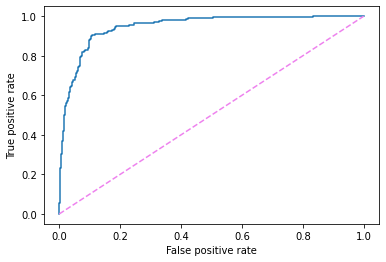

In [36]:
specificity, recall, thresholds = roc_curve(y_val, lm.predict_proba(X_val)[:,1], pos_label=1)
plt.plot(specificity, recall);
plt.plot([0, 1], [0, 1], color='violet', linestyle='--');
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, lm.predict_proba(X_val)[:,1]))

In [37]:
X_train.shape

(11139, 11)

### KNN

K-Nearest Neighbors is chosen because it could be useful for finding similarities in features between objects that are active satellites and non-active objects.   

In [38]:
knn_scores = []

# find the best number of neighbors to use for KNN algorithm
for k in range(1,21):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    score = accuracy_score(y_val, knn.predict(X_val))
    knn_scores.append((score, k))
    
print('k =', max(knn_scores)[1], 'gives the highest accuracy of {:6.4f}'.format(max(knn_scores)[0]))

k = 1 gives the highest accuracy of 0.9507


In [39]:
# k = 1 classifies all objects as one class, so that doesn't really help with classification
# k = 5 was chosen because it seemed to give the highest f1-score overall
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_val)
knn_score = classification_report(y_val, y_knn)
print(knn_score)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3321
           1       0.75      0.74      0.75       393

    accuracy                           0.95      3714
   macro avg       0.86      0.86      0.86      3714
weighted avg       0.95      0.95      0.95      3714



ROC AUC score =  0.9475214783247634


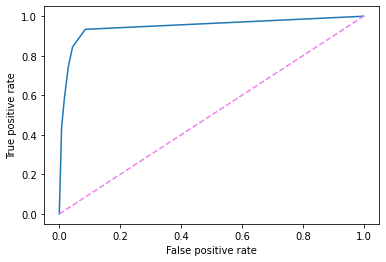

In [40]:
specificity, recall, thresholds = roc_curve(y_val, knn.predict_proba(X_val)[:,1], pos_label=1)
plt.plot(specificity, recall);
plt.plot([0, 1], [0, 1], color='violet', linestyle='--');
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))

### Random Forest

Random Forest models use Decision Trees, which are comprehensible and in this case consider all possible features for an object and trace each path to the most likely class (active satellite or not). Random Forests further improve on Decision Trees because they are an ensemble of trees.

In [41]:
random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=10)
random_forest.fit(X_train, y_train)
y_rfc = random_forest.predict(X_val)
random_forest_score = classification_report(y_val, y_rfc)
print(random_forest_score)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3321
           1       0.89      0.81      0.85       393

    accuracy                           0.97      3714
   macro avg       0.93      0.90      0.92      3714
weighted avg       0.97      0.97      0.97      3714



ROC AUC score =  0.9828483710338941


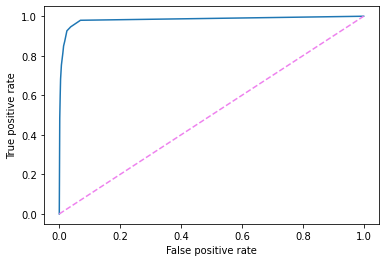

In [42]:
specificity, recall, thresholds = roc_curve(y_val, random_forest.predict_proba(X_val)[:,1], pos_label=1)
plt.plot(specificity, recall);
plt.plot([0, 1], [0, 1], color='violet', linestyle='--');
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, random_forest.predict_proba(X_val)[:,1]))

### XGBoost

XGBoost uses gradient boosting, which similar to Random Forests, uses an emsemble of decision trees for modeling. However, gradient boosting uses shallow, pruned trees (high bias, low variance) while Random Forests use fully grown decision trees (low bias, high variance). Boosting reduces bias, while Random Forests reduce variance. It would be interesting to see how gradient boosting compares to Random Forests in classifying space objects.

In [43]:
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=5,
                       objective='binary:logistic',
                       scale_pos_weight=weight,
                       learning_rate=1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train), (X_val,y_val)] #tracking train/validation error as we go

gbm.fit( 
        X_train, y_train, 
        eval_set=eval_set,
        eval_metric='error',
        early_stopping_rounds=20,
        verbose=False #does not give output log as below
       )

y_xgb = gbm.predict(X_val)
xgboost_score = classification_report(y_val, y_xgb)
print(xgboost_score)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3321
           1       0.87      0.90      0.88       393

    accuracy                           0.97      3714
   macro avg       0.93      0.94      0.93      3714
weighted avg       0.98      0.97      0.97      3714



ROC AUC score =  0.9908072080438078


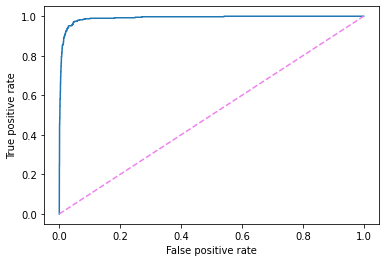

In [44]:
specificity, recall, thresholds = roc_curve(y_val, gbm.predict_proba(X_val)[:,1], pos_label=1)
plt.plot(specificity, recall);
plt.plot([0, 1], [0, 1], color='violet', linestyle='--');
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print("ROC AUC score = ", roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1]))

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

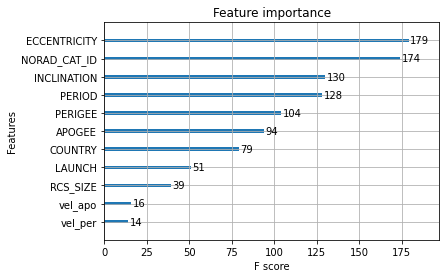

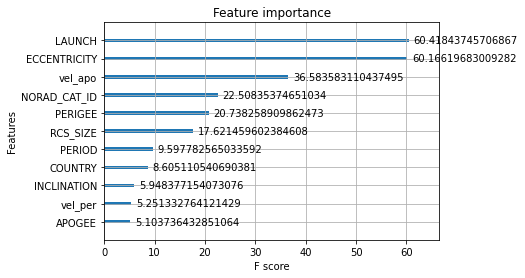

In [45]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

The 'Gain' implies the relative contribution of a corresponding feature to a model calculated by taking each feature’s contribution for each tree. The three features selected from the pairplot to be further analyzed earlier (Launch, Eccentricity, and Norad_Cat_ID) seemed to contribute heavily to the gain of a tree when using XGBoost, which further supports the patterns noticed in the pairplot when conducting EDA. The velocity at apogee, which was an additional feature added during feature engineering, also contributes heavily to the gain of the model. 

### Confusion Matrices

Plot the confusion matrices for the four machine learning models used to analyze how well the models predict true positives and true negatives as well as mispredict in false positives and false negatives.

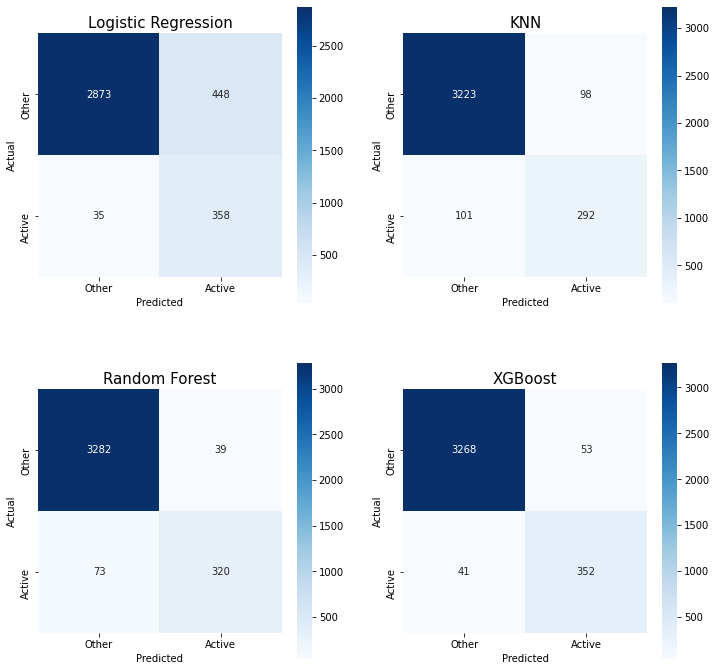

In [46]:
models = zip(range(1,5),
             ['Logistic Regression', 'KNN', 'Random Forest', 'XGBoost'],
             [y_lm, y_knn, y_rfc, y_xgb])
plt.figure(figsize=(12,12))

for ind, name, pred in models:
    plt.subplot(2, 2, ind)
    cm = confusion_matrix(y_val, pred)
    ax = sns.heatmap(cm,
                cmap=plt.cm.Blues,
                annot=True,
                square=True,
                xticklabels=['Other', 'Active'],
                yticklabels=['Other', 'Active'],
                fmt='g')
    ax.set_ylim(2, 0)
    plt.title(name, size=15);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

RF and XGBoost seems to have the most true positive and true negatives. Logistic Regression seems to be making a lot of false positive predictions. KNN seems to be making double the amount of false positive and false negative predictions as RF and XGBoost.

### Adjust Threshold with Slider for XGBoost Model

Adjusting the probability threshold for an object to be predicted as an active satellite to increase number of true positive and true negative predictions.

In [47]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = model.predict_proba(X_val)[:, 1] >= threshold
    #y_predict = [str(int(i)) for i in pred]
    cm = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['other', 'actual'],
           yticklabels=['other', 'actual']);
    ax.set_ylim(2, 0)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [48]:
interactive(lambda threshold: make_confusion_matrix(gbm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Threshold Adustment to Optimize F1

Automate threshold adjustment to obtain the best thresholds that optimize the F1 score for each model.

In [49]:
models = zip(range(1,5),
                 ['Logistic Regression', 'KNN', 'Random Forest', 'XGBoost'],
                 [lm, knn, random_forest, gbm])

def f1_plot(models):    
    plt.figure(figsize=(12,12))
    
    for ind, name, model in models:
        model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs 
        f1_scores = []
        thresh_ps = np.linspace(0.01, 0.99, 1000)
    
        for p in thresh_ps:
            model_val_labels = model_val_probs >= p
            f1_scores.append(f1_score(y_val, model_val_labels, labels=np.unique(y_val)))
       
        plt.subplot(2, 2, ind)
        plt.plot(thresh_ps, f1_scores)
        plt.title(name, size=15)
        plt.xlabel('P threshold')
        plt.ylabel('F1 score')

        best_f1_score = np.max(f1_scores) 
        best_thresh_p = thresh_ps[np.argmax(f1_scores)]
        print(name, 'Model best F1 score %.3f at prob decision threshold >= %.3f' 
        % (best_f1_score, best_thresh_p))

Logistic Regression Model best F1 score 0.666 at prob decision threshold >= 0.629
KNN Model best F1 score 0.763 at prob decision threshold >= 0.200
Random Forest Model best F1 score 0.867 at prob decision threshold >= 0.200
XGBoost Model best F1 score 0.885 at prob decision threshold >= 0.553


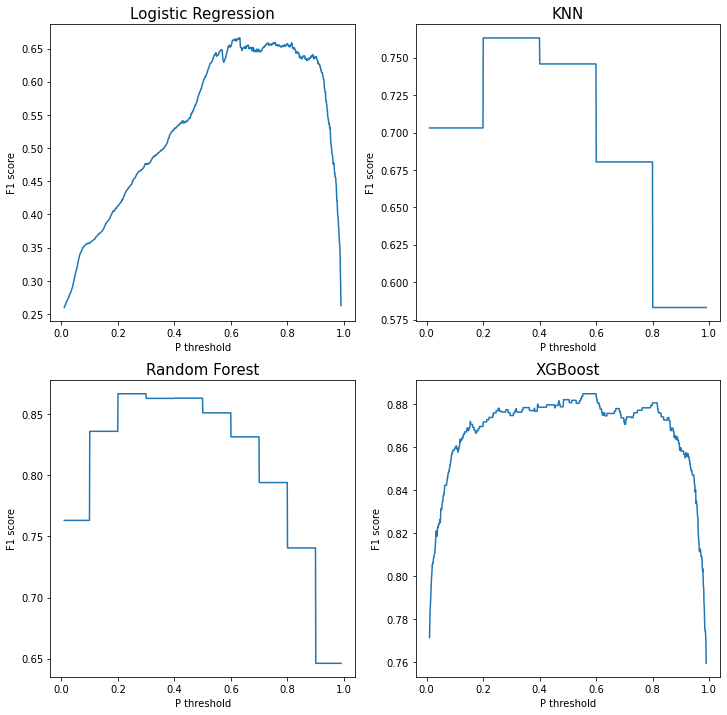

In [50]:
f1_plot(models)

### Cross Validation

Run cross validation with adjusted thresholds to resample data to evaluate the effectiveness of all four machine learning models. 

In [51]:
X_, y_ = np.array(X_80), np.array(y_80)

kf = KFold(n_splits=10, random_state=42)

lm_accuracy = []
lm_precision = []
lm_recall = []
lm_f1 = []

knn_accuracy = []
knn_precision = []
knn_recall = []
knn_f1 = []

rf_accuracy = []
rf_precision = []
rf_recall = []
rf_f1 = []

xgb_accuracy = []
xgb_precision = []
xgb_recall = []
xgb_f1 = []

for train_ind, val_ind in kf.split(X_,y_):
    
    X_train, y_train = X_[train_ind], y_[train_ind]
    X_val, y_val = X_[val_ind], y_[val_ind]
    
    # logistic regression
    lm.fit(X_train, y_train)
    lm_probs = lm.predict_proba(X_val)[:,1]
    lm_labels = lm_probs >= 0.629
    
    lm_accuracy.append(accuracy_score(y_val, lm_labels))
    lm_precision.append(precision_score(y_val, lm_labels)) 
    lm_recall.append(recall_score(y_val, lm_labels))
    lm_f1.append(f1_score(y_val, lm_labels))
    
    # knn
    knn.fit(X_train, y_train)
    knn_probs = knn.predict_proba(X_val)[:,1]
    knn_labels = knn_probs >= 0.3
    
    knn_accuracy.append(accuracy_score(y_val, knn_labels))
    knn_precision.append(precision_score(y_val, knn_labels)) 
    knn_recall.append(recall_score(y_val, knn_labels))
    knn_f1.append(f1_score(y_val, knn_labels))
    
    # random forest
    random_forest.fit(X_train, y_train)
    rf_probs = random_forest.predict_proba(X_val)[:,1]
    rf_labels = rf_probs >= 0.5
    
    rf_accuracy.append(accuracy_score(y_val, rf_labels))
    rf_precision.append(precision_score(y_val, rf_labels)) 
    rf_recall.append(recall_score(y_val, rf_labels))
    rf_f1.append(f1_score(y_val, rf_labels))
    
    # xgboost
    eval_set=[(X_train,y_train), (X_val,y_val)] #tracking train/validation error as we go

    gbm.fit( 
            X_train, y_train, 
            eval_set=eval_set,
            eval_metric='error',
            early_stopping_rounds=20,
            verbose=False #does not give output log as below
           )
                        
    xgb_probs = gbm.predict_proba(X_val)[:,1]
    xgb_labels = xgb_probs > 0.5
    
    xgb_accuracy.append(accuracy_score(y_val, xgb_labels))
    xgb_precision.append(precision_score(y_val, xgb_labels)) 
    xgb_recall.append(recall_score(y_val, xgb_labels))
    xgb_f1.append(f1_score(y_val, xgb_labels))

print('Logistic Regression cross-val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n' %
        (np.mean(lm_accuracy), np.mean(lm_precision), np.mean(lm_recall), np.mean(lm_f1)
        )
     )

print('KNN cross-val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n' %
        (np.mean(knn_accuracy), np.mean(knn_precision), np.mean(knn_recall), np.mean(knn_f1)
        )
     )

print('Random Forest cross-val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n' %
        (np.mean(rf_accuracy), np.mean(rf_precision), np.mean(rf_recall), np.mean(rf_f1)
        )
     )

print('XGB cross-val metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n' %
        (np.mean(xgb_accuracy), np.mean(xgb_precision), np.mean(xgb_recall), np.mean(xgb_f1)
        )
     )

Logistic Regression cross-val metrics: 
 Accuracy: 0.9148 
 Precision: 0.5627 
 Recall: 0.8022 
 F1: 0.6609 

KNN cross-val metrics: 
 Accuracy: 0.9480 
 Precision: 0.7051 
 Recall: 0.8551 
 F1: 0.7725 

Random Forest cross-val metrics: 
 Accuracy: 0.9719 
 Precision: 0.8619 
 Recall: 0.8677 
 F1: 0.8644 

XGB cross-val metrics: 
 Accuracy: 0.9720 
 Precision: 0.8264 
 Recall: 0.9227 
 F1: 0.8718 



From the cross validation, the Random Forest and XGBoost models seem to have the highest F1 and AUC scores. This means that they had the highest number of true positive and true negative predictions and limited the number of false positive and false negative predictions. 

### Predicting on Test Set

From the cross validation, the Random Forest and XGBoost models were selected to make predictions on the reserved test set.

Random Forest test metrics: 
 Accuracy: 0.9721 
 Precision: 0.8611 
 Recall: 0.8694 
 F1: 0.8649 
 AUC: 0.9355 

XGB test metrics: 
 Accuracy: 0.9722 
 Precision: 0.8270 
 Recall: 0.9212 
 F1: 0.8715 
 AUC: 0.9439 



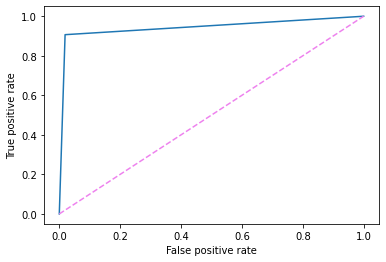

In [52]:
random_forest.fit(X_80, y_80)
rf_probs = random_forest.predict_proba(X_test)[:,1]
rf_labels = rf_probs >= 0.5

rf_accuracy.append(accuracy_score(y_test, rf_labels))
rf_precision.append(precision_score(y_test, rf_labels)) 
rf_recall.append(recall_score(y_test, rf_labels))
rf_f1.append(f1_score(y_test, rf_labels))


eval_set=[(X_80, y_80), (X_test, y_test)]

gbm.fit( 
        X_80, y_80, 
        eval_set=eval_set,
        eval_metric='error',
        early_stopping_rounds=20,
        verbose=False #does not give output log as below
       )

xgb_probs = gbm.predict_proba(X_test)[:,1]
xgb_labels = xgb_probs > 0.5

xgb_accuracy.append(accuracy_score(y_test, xgb_labels))
xgb_precision.append(precision_score(y_test, xgb_labels)) 
xgb_recall.append(recall_score(y_test, xgb_labels))
xgb_f1.append(f1_score(y_test, xgb_labels))

rf_auc = roc_auc_score(y_test, rf_labels)
xgb_auc = roc_auc_score(y_test, xgb_labels)

print('Random Forest test metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n AUC: %.4f \n' %
        (np.mean(rf_accuracy), np.mean(rf_precision), np.mean(rf_recall), np.mean(rf_f1), rf_auc
        )
     )

print('XGB test metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n AUC: %.4f \n' %
        (np.mean(xgb_accuracy), np.mean(xgb_precision), np.mean(xgb_recall), np.mean(xgb_f1), xgb_auc
        )
     )

specificity, recall, thresholds = roc_curve(y_test, xgb_labels, pos_label=1)
plt.plot(specificity, recall);
plt.plot([0, 1], [0, 1], color='violet', linestyle='--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');

The Random Forest and XGBoost models seem to perform similarly to cross validation. The F1 scores are about 0.86-0.87 and the AUC scores are around 0.93-0.94, which are very close to a perfect AUC score of 1. This means that these models are classifying most of the space objects as true positives and true negatives, as an AUC score of 1 means that 100% of the predictions made are correct. The high AUC score also indicates high performance across all possible classification thresholds, as a random positive sample is probabilistically ranked more highly than a random negative sample. 

### Converting Testing Data to JSON to Map Predictions

Since the XGBoost model performs slightly better than the Random Forest model, the XGBoost model predictions on the test set are chosen to be mapped on a spinning globe animation made in D3.js with true positives colored green, false positives colored red, and objects from the training set colored gray. Before doing so, the data needs to be converted into JSON format.

In [53]:
map_sats = X_test
map_sats['predict_probs'] = xgb_probs * 100
map_sats['predict'] = xgb_labels
map_sats['actual'] = y_test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A val

In [54]:
map_sats = map_sats[map_sats['actual'] == 1]

In [55]:
map_sats = map_sats.drop(columns = 'actual')

In [56]:
def format(percent):
    return '{:6.2f}'.format(percent)

map_sats['predict_probs'] = map_sats['predict_probs'].apply(lambda p: format(p))

In [57]:
map_sats

,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH,ECCENTRICITY,vel_apo,vel_per,predict_probs,predict
3424,40613,53,1436.07,0.01,35798.0,35774.0,2.0,2015.0,0.000285,3076.236018,3077.111815,100.00,True
5469,37849,4,101.44,98.71,827.0,826.0,2.0,2011.0,0.000069,7446.212108,7446.729475,99.98,True
4601,39034,8,1436.10,0.08,35805.0,35768.0,2.0,2012.0,0.000439,3075.980718,3077.330881,100.00,True
1598,42767,5,94.78,97.46,514.0,502.0,2.0,2017.0,0.000872,7613.611698,7620.256306,94.02,True
1521,42854,4,93.53,96.92,454.0,440.0,0.0,2017.0,0.001027,7647.009775,7654.866102,99.99,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,43137,4,94.51,97.48,501.0,489.0,0.0,2018.0,0.000874,7620.810809,7627.474300,99.79,True
10751,29499,33,101.30,98.56,821.0,820.0,2.0,2006.0,0.000070,7449.317931,7449.835947,94.09,True
3875,40025,65,96.71,97.90,610.0,592.0,0.0,2014.0,0.001291,7561.073210,7570.841341,0.77,False
2358,41926,4,100.40,86.40,779.0,776.0,2.0,2017.0,0.000210,7471.168062,7472.736153,100.00,True


In [58]:
map_sats[map_sats['predict'] == 1]

,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH,ECCENTRICITY,vel_apo,vel_per,predict_probs,predict
3424,40613,53,1436.07,0.01,35798.0,35774.0,2.0,2015.0,0.000285,3076.236018,3077.111815,100.00,True
5469,37849,4,101.44,98.71,827.0,826.0,2.0,2011.0,0.000069,7446.212108,7446.729475,99.98,True
4601,39034,8,1436.10,0.08,35805.0,35768.0,2.0,2012.0,0.000439,3075.980718,3077.330881,100.00,True
1598,42767,5,94.78,97.46,514.0,502.0,2.0,2017.0,0.000872,7613.611698,7620.256306,94.02,True
1521,42854,4,93.53,96.92,454.0,440.0,0.0,2017.0,0.001027,7647.009775,7654.866102,99.99,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4274,39533,4,718.01,53.86,20296.0,20070.0,2.0,2014.0,0.004256,3868.407504,3884.905231,96.95,True
1282,43137,4,94.51,97.48,501.0,489.0,0.0,2018.0,0.000874,7620.810809,7627.474300,99.79,True
10751,29499,33,101.30,98.56,821.0,820.0,2.0,2006.0,0.000070,7449.317931,7449.835947,94.09,True
2358,41926,4,100.40,86.40,779.0,776.0,2.0,2017.0,0.000210,7471.168062,7472.736153,100.00,True


In [59]:
active = satellites[['name', 'NORAD_CAT_ID', 'lon']]
active

,name,NORAD_CAT_ID,lon
0,3Cat-1,43728,0.0
1,Aalto-1,42775,0.0
2,AAUSat-4,41460,0.0
3,"ABS-2 (Koreasat-8, ST-3)",39508,75.0
4,ABS-2A,41588,-75.0
...,...,...,...
2057,Zhuhai-1-02 (OVS-1B),52759,0.0
2058,Zhuhai-1-03 (OVS-2A),43440,0.0
2059,Ziyuan 1-02C,38038,0.0
2060,Ziyuan 3 (ZY-3),38046,0.0


In [60]:
map_sats = map_sats.merge(active)

In [61]:
map_sats = map_sats.drop_duplicates(subset='NORAD_CAT_ID')

In [62]:
map_sats['lat'] = np.random.uniform(-180, 180, len(map_sats))

In [63]:
train_dat = X_80
train_dat['actual'] = y_80
train_dat = train_dat[train_dat['actual'] == 1]
train_dat['predict_probs'] = 0
train_dat['predict'] = 2
train_dat = train_dat.merge(active)
train_dat= train_dat.drop_duplicates(subset='NORAD_CAT_ID')
train_dat['lat'] = np.random.uniform(-180, 180, len(train_dat))
train_dat = train_dat.drop(columns = 'actual')
train_dat

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH,ECCENTRICITY,vel_apo,vel_per,predict_probs,predict,name,lon,lat
0,43831,22,95.49,97.60,551.0,534.0,2.0,2018.0,0.001230,7593.233058,7602.575873,0,2,Saudisat-5A,0.0,80.850241
1,26985,4,1429.41,0.13,35679.0,35632.0,2.0,2001.0,0.000559,3080.585866,3082.308963,0,2,DirecTV-4S,-101.2,-96.708135
2,41977,4,94.39,97.40,495.0,482.0,0.0,2017.0,0.000948,7624.140370,7631.369417,0,2,Dove 3p-58 (0 Flock 3P-58 1009),0.0,-144.172177
3,40286,1,98.51,98.07,696.0,679.0,2.0,2014.0,0.001204,7514.919588,7523.975958,0,2,Shijian 11-08 (SJ-11-08),0.0,56.612746
4,41179,17,98.98,47.00,713.0,707.0,1.0,2015.0,0.000424,7505.895843,7509.076981,0,2,ORBCOMM OG2 FM-114,0.0,-121.131831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,40483,4,5035.01,19.44,177536.0,4329.0,2.0,2015.0,0.890044,1473.035472,6107.163692,0,2,MMS-2 (Magnetospheric Multiscale Mission),0.0,98.067143
1546,36798,48,98.19,98.01,673.0,672.0,1.0,2010.0,0.000071,7527.180150,7527.714580,0,2,Alsat-2A (Algeria Satellite 2A),0.0,-56.176085
1547,43672,0,97.02,97.85,617.0,615.0,2.0,2018.0,0.000143,7557.284690,7558.366543,0,2,GOSAT-2 (Greenhouse gases Observing Satellite-...,0.0,-155.636532
1548,42841,4,96.50,97.55,600.0,582.0,0.0,2017.0,0.001293,7566.495278,7576.284466,0,2,Lemur-2-PeterG (Lemur 2F48),0.0,-70.655062


In [64]:
map_sats = pd.concat([map_sats, train_dat])

In [65]:
map_sats

,NORAD_CAT_ID,COUNTRY,PERIOD,INCLINATION,APOGEE,PERIGEE,RCS_SIZE,LAUNCH,ECCENTRICITY,vel_apo,vel_per,predict_probs,predict,name,lon,lat
0,40613,53,1436.07,0.01,35798.0,35774.0,2.0,2015.0,0.000285,3076.236018,3077.111815,100.00,1,Thor-7,-1.0,176.028162
1,37849,4,101.44,98.71,827.0,826.0,2.0,2011.0,0.000069,7446.212108,7446.729475,99.98,1,NPP (National Polar-orbiting Operational Envir...,0.0,101.180366
2,39034,8,1436.10,0.08,35805.0,35768.0,2.0,2012.0,0.000439,3075.980718,3077.330881,100.00,1,Skynet 5D,25.0,55.103046
3,42767,5,94.78,97.46,514.0,502.0,2.0,2017.0,0.000872,7613.611698,7620.256306,94.02,1,CartoSat 2E,0.0,-71.241741
4,42854,4,93.53,96.92,454.0,440.0,0.0,2017.0,0.001027,7647.009775,7654.866102,99.99,1,Dove 2k-47 (0 Flock 2K-47 1043),0.0,92.656106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,40483,4,5035.01,19.44,177536.0,4329.0,2.0,2015.0,0.890044,1473.035472,6107.163692,0,2,MMS-2 (Magnetospheric Multiscale Mission),0.0,98.067143
1546,36798,48,98.19,98.01,673.0,672.0,1.0,2010.0,0.000071,7527.180150,7527.714580,0,2,Alsat-2A (Algeria Satellite 2A),0.0,-56.176085
1547,43672,0,97.02,97.85,617.0,615.0,2.0,2018.0,0.000143,7557.284690,7558.366543,0,2,GOSAT-2 (Greenhouse gases Observing Satellite-...,0.0,-155.636532
1548,42841,4,96.50,97.55,600.0,582.0,0.0,2017.0,0.001293,7566.495278,7576.284466,0,2,Lemur-2-PeterG (Lemur 2F48),0.0,-70.655062


In [66]:
def makedict(row):
    d = {}
    d["type"] = "Point"
    d["coordinates"] = [row['lon'], row['lat']]
    d["predict"] = row['predict']
    return d

In [67]:
d = {"type": "Topology","objects": 
    {"plane1": map_sats.apply(makedict,axis=1).tolist()}}

In [68]:
import json

In [69]:
with open('points.json', 'w') as json_file:
    json.dump(d, json_file)